In [1]:
import pandas as pd
import numpy as np
filepath = 'train.tsv'
filepath1 = 'dev_part1.tsv'
df = pd.read_csv(filepath, sep='\t', encoding = 'utf-8')
wf = pd.read_csv(filepath1, sep='\t', encoding = 'utf-8')

df.head() 

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x81 in position 166: invalid start byte

In [57]:
sentences = df['Sentence']
target = df['RE_Type']
PMID = df['PMID']
Gene1 = df['Gene1|Gene1_ID']
Gene2 = df['Gene2|Gene2_ID']

In [58]:
import nltk
from nltk.tokenize import word_tokenize

In [59]:
from nltk.corpus import stopwords
english_stopwords = stopwords.words("english")

In [60]:
sentences = sentences.str.replace('/', ',')

1.分句

In [61]:
import nltk
from nltk.tokenize import sent_tokenize
sen1=[]
for i in sentences:
    sen1.append(sent_tokenize(i))

In [62]:
sen1[375]

['Taken together, these observations indicate that PLD1 is activated by PLCg,PKCa signaling and stimulate Bcl-2 expression through PLA2,Cox2,EP4,PKA,p38MAPK,CREB during neuronal differentiation of rat neural stem cells.']

2.分詞

In [63]:
sen = []
for i in sentences:
    sen.append(word_tokenize(i))

In [64]:
temp1 = []
english_punctuations = [',', '/']
for i in range(0, len(sen)):
    for j in sen[i]:
        if j not in english_stopwords: # 過濾停用詞
            if j not in english_punctuations: # 過濾標點符號
                temp1.append(j)
    sen[i] = temp1
    temp1 = []

將Gene1進行分割 只留下純文字的部分

In [65]:
gene11 = []
gene22 = []
for i in range(0, len(Gene1)):
    gene11.append(Gene1[i].split('|')[0])
    gene22.append(Gene2[i].split('|')[0])

In [66]:
gene1 = []
gene2 = []
for i in range(0, len(Gene1)):
    gene1.append(gene11[i].split('/')[0])
    gene2.append(gene22[i].split('/')[0])

In [67]:
ge1 = []
for i in gene1:
    ge1.append(word_tokenize(i))

In [68]:
ge2 = []
for i in gene2:
    ge2.append(word_tokenize(i))

In [69]:
g1 = []
for i in range(0, len(ge1)):
    if len(ge1[i]) > 1:
        g1.append("".join(ge1[i][0]))
    else:
        g1.append("".join(ge1[i]))

g2 = []
for i in range(0, len(ge2)):
    if len(ge2[i]) > 1:
        g2.append("".join(ge2[i][0]))
    else:
        g2.append("".join(ge2[i]))

將target轉化成數字

In [70]:
label_dict = dict()
label_set = set()
for l in target:
    label_set.add(l)
for ll in label_set:
    label_dict[ll] = len(label_dict)
label_dict_inverse = {v : k for k, v in label_dict.items()}

In [71]:
from keras.utils import to_categorical
target_int = [label_dict[ll] for ll in target]
target_onehot = to_categorical(target_int, num_classes=len(label_dict))

In [72]:
word = []
train_list = []
for i in range(0, len(target)):
    word.append([Gene1[i], Gene2[i]])
    train_list.append([word[i], target_onehot[i]])
train_list = np.array(train_list)

進行語料庫的建立

In [73]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(sen, size = 300, window = 5, min_count = 1)

此函數是用來找前十名最接近輸入詞的詞

In [74]:
def most_similar(w2v_model, words, topn=10):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df

In [75]:
most_similar(model, ['Notably'])

,Notably,cos
0,tumor-only,0.970837
1,FFPE,0.968498
2,panel-based,0.966300
3,Il17f,0.963987
4,vpr,0.963517
5,Marfan,0.962936
6,CLL-induced,0.962472
7,side,0.962354
8,neuroinflammatory,0.962149
9,K17-,0.961277


此函數用來找兩個詞之間的關係（餘弦值）

In [76]:
def similarity(word1, word2):
    try:
        val = model.similarity(word1, word2)
    except:
        val = 0.5
    return val

計算每一組Gene1和Gene2的關係值

In [77]:
cos = []
for i in range(0, len(g1)):
    cos.append(similarity(g1[i], g2[i]))

/Users/harry02261112/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [92]:
from sklearn import ensemble, preprocessing, metrics
from sklearn.model_selection import train_test_split
X = cos
X = np.array(X)
y = target_onehot

##target_new

y = np.array(y)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3)

# 建立 random forest 模型
forest = ensemble.RandomForestClassifier(n_estimators = 100)
forest_fit = forest.fit(train_X.reshape(-1, 1), train_y)

# 預測"
test_y_predicted = forest.predict(test_X.reshape(-1, 1))
train_y_predicted = forest.predict(train_X.reshape(-1, 1))

# 績效
accuracy_test_forest = metrics.accuracy_score(test_y, test_y_predicted)
accuracy_train_forest = metrics.accuracy_score(train_y, train_y_predicted)
print(accuracy_test_forest,accuracy_train_forest)

0.7379698787804579 0.8686434006822357


In [79]:
y_null = []
for i in range(0, len(test_y)):
    y_null.append('NoRE')
    
accuracy = metrics.accuracy_score(test_y, test_y_predicted)
print(accuracy)

0.7395616505448758


In [80]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.svm import SVR

In [81]:
print("Random Forests: ")
forest = ensemble.RandomForestClassifier(n_estimators = 100)
accuracy = cross_val_score(forest, X.reshape(-1, 1),y,scoring='accuracy', cv = 5)
print("Accuracy of Random Forests is: " , accuracy.mean())
print("\n\nknn:")
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(knn,X.reshape(-1, 1),y,cv=5,scoring='accuracy')
print(scores.mean())
print("Accuracy of Knn is: " , scores.mean())
print("\n\nSVM:")
y = target
svm_class = SVC(kernel = 'linear')
accuracy = cross_val_score(svm_class, X.reshape(-1, 1), y, scoring='accuracy', cv = 5).mean()
print("Accuracy of SVM is: " , accuracy)

Random Forests: 
Accuracy of Random Forests is:  0.7201891400815988


knn:
0.7718383082714123
Accuracy of Knn is:  0.7718383082714123


SVM:


/Users/harry02261112/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy of SVM is:  0.8185302571581385


In [82]:
x1 = wf['Gene1|Gene1_ID']
x2 = wf['Gene2|Gene2_ID']
xx1 = []
xx2 = []
for i in range(0, len(x1)):
    xx1.append(x1[i].split('|')[0])
    xx2.append(x2[i].split('|')[0])
cos_dev = []
for i in range(0, len(x1)):
    cos_dev.append(similarity(xx1[i], xx2[i]))

/Users/harry02261112/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [83]:
X = cos
X = np.array(X)
y = target
y = np.array(y)

# 建立SVM模型
svm_class = SVC(kernel = 'linear')
svm_class.fit(X.reshape(-1, 1), y)

# 預測
cos_dev = np.array(cos_dev)
predicted = svm_class.predict(cos_dev.reshape(-1, 1))

In [84]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression() #初始化 LR model
X = cos
X = np.array(X)
y = target
y = np.array(y)

classifier.fit(X.reshape(-1, 1), y)
cos_dev = np.array(cos_dev)
predicted = classifier.predict(cos_dev.reshape(-1, 1))

In [85]:
X = cos
#vector_plus
X = np.array(X)
y = target
y = np.array(y)

# 建立SVM模型
svm_class = SVC(kernel = 'linear')
svm_class.fit(X.reshape(-1, 1), y)#.reshape(-1, 1)

# 預測
cos_dev = np.array(cos_dev)
predicted = svm_class.predict(cos_dev.reshape(-1, 1))#.reshape(-1, 1)
#vec_dev

In [86]:
# k fold cross validation 

from sklearn.model_selection import KFold
import numpy as np
kf = KFold(n_splits=5)
X = train_X
y = train_y

# Random Forest

validation_acc_forest = np.array([])
for train_index, test_index in kf.split(X):
    X_train_forest, X_test_forest = X[train_index], X[test_index]
    y_train_forest, y_test_forest = y[train_index], y[test_index]
    forest = ensemble.RandomForestClassifier(n_estimators = 100)
    forest_fit = forest.fit(X_train_forest.reshape(-1, 1), y_train_forest)
    y_test_predicted_forest = forest.predict(X_test_forest.reshape(-1, 1))
    accuracy_forest = metrics.accuracy_score(y_test_forest, y_test_predicted_forest)
    validation_acc_forest = np.append(validation_acc_forest,round(accuracy_forest,2))
print(validation_acc_forest)
val_accuracy_forest = round(np.mean(validation_acc_forest),2)
print("The mean accuracy of the random forest validations :",val_accuracy_forest)
print("\n\n")

# KNN

validation_acc_knn = np.array([])
for train_index, test_index in kf.split(X):
    X_train_knn, X_test_knn = X[train_index], X[test_index]
    y_train_knn, y_test_knn = y[train_index], y[test_index]
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train_knn.reshape(-1, 1),y_train_knn)
    y_test_predicted_knn = knn.predict(X_test_knn.reshape(-1, 1))
    accuracy_knn = metrics.accuracy_score(y_test_knn, y_test_predicted_knn)
    validation_acc_knn = np.append(validation_acc_knn,round(accuracy_knn,2))
print(validation_acc_knn)
val_accuracy_knn = round(np.mean(validation_acc_knn),2)
print("The mean accuracy of the knn validations :",val_accuracy_knn)
print("\n\n")

# SVM

validation_acc_svm = np.array([])
y = np.array(target_int)
for train_index, test_index in kf.split(X):
    X_train_svm, X_test_svm = X[train_index], X[test_index]
    y_train_svm, y_test_svm = y[train_index], y[test_index]
    svm = SVR(kernel = 'linear')
    svm.fit(X_train_svm.reshape(-1, 1),y_train_svm)
    y_test_predicted_svm = svm.predict(X_test_svm.reshape(-1, 1))
    y_test_predicted_svm_one_hot = to_categorical(y_test_predicted_svm, num_classes=len(label_dict))
    y_test_svm_one_hot = to_categorical(y_test_svm, num_classes=len(label_dict))
    accuracy_svm = metrics.accuracy_score(y_test_svm_one_hot, y_test_predicted_svm_one_hot)
    validation_acc_svm = np.append(validation_acc_svm,round(accuracy_svm*350,2))
print(validation_acc_svm)
val_accuracy_svm = round(np.mean(validation_acc_svm),2)
print("The mean accuracy of the svm validations :",val_accuracy_svm)

[0.74 0.72 0.73 0.73 0.73]
The mean accuracy of the random forest validations : 0.73



[0.79 0.77 0.77 0.78 0.78]
The mean accuracy of the knn validations : 0.78



[0.73 0.73 0.37 0.46 0.46]
The mean accuracy of the svm validations : 0.55


寫入檔案

In [87]:
pre = pd.DataFrame({'RE_Type':predicted})

In [88]:
wf = pd.concat([wf, pre], sort = False, axis = 1)

In [93]:
wf.to_csv("prediction_sentence.tsv", encoding = 'utf-8', sep = '\t', index = False)

Visualization

In [90]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib import pyplot

/Users/harry02261112/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


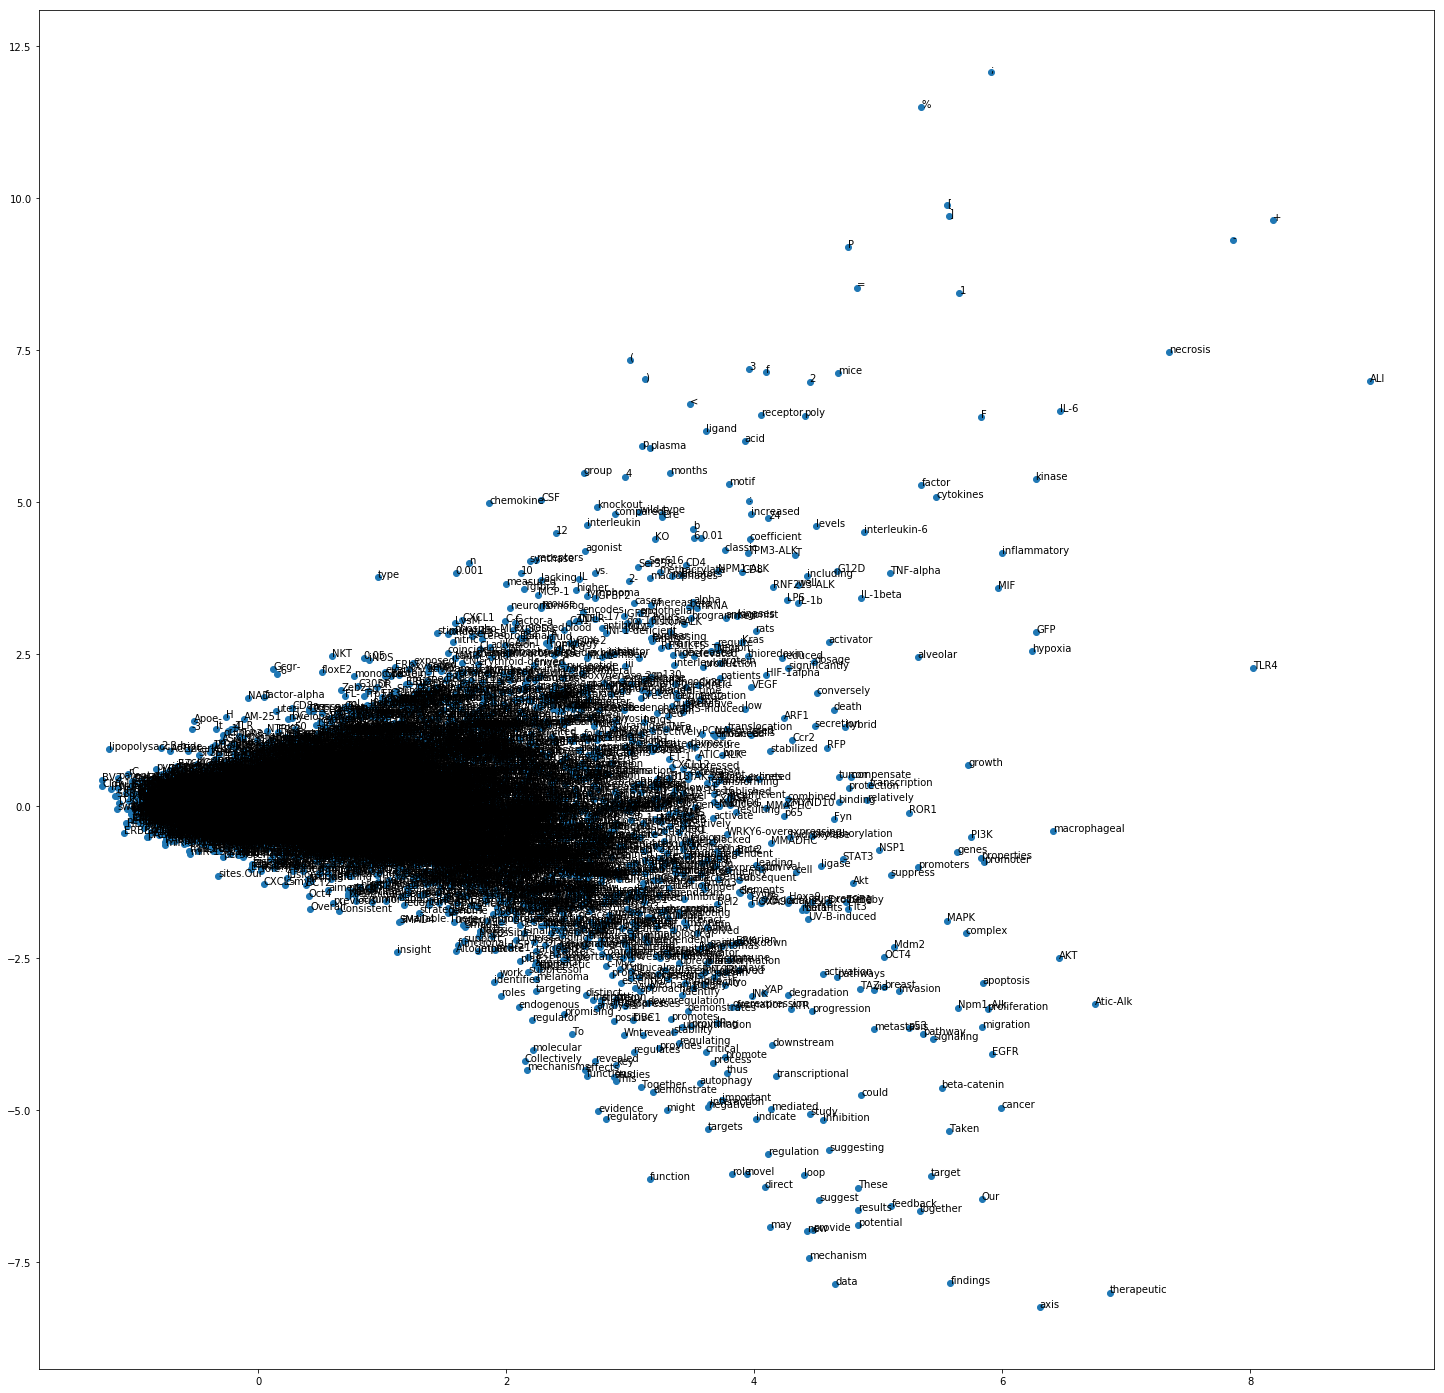

In [91]:
# PCA
plt.figure(figsize=(25, 25))
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()
